# BoolForge Tutorial 6: Working with Boolean Networks

While previous tutorials focused on individual Boolean functions, this tutorial
introduces Boolean networks, which combine multiple Boolean functions into a
dynamical system.

## What you will learn
In this tutorial you will learn how to:

- create Boolean networks,
- compute basic properties of the wiring diagram,
- compute basic properties of Boolean networks.

---
## 0. Setup

In [1]:
import boolforge
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

---
## 1. Boolean network theory

A Boolean network $F = (f_1, \ldots, f_N)$ is a dynamical system consisting of
$N$ Boolean update functions. Each node can be in one of two states, 0 or 1,
often interpreted as OFF/ON in biological contexts.

Under synchronous updating, all nodes update simultaneously, yielding a
deterministic state transition graph on $\{0,1\}^N$.

Under asynchronous updating, only one node is updated at a time, yielding a
stochastic transition graph. BoolForge implements both schemes.

Real biological networks are typically sparsely connected. The **in-degree**
of a node is the number of essential inputs of its update function. The
**wiring diagram** encodes which nodes regulate which others.

Despite their simplicity, Boolean networks can:
- reproduce complex dynamics (oscillations, multistability),
- predict gene knockout effects,
- identify control strategies,
- scale to genome-wide networks (1000s of nodes).

---
## 2. Wiring diagrams

We first construct wiring diagrams, which encode network structure independently
of specific Boolean functions.

Separating topology (I) from dynamics (F) allows:
- studying structural properties independent of specific Boolean rules,
- swapping different rule sets on the same topology,
- efficient storage (sparse I, local F vs dense full truth table).

W.N: 3
W.variables: ['x0' 'x1' 'x2']
W.indegrees: [1 2 1]
W.outdegrees: [1 2 1]
W.N_constants: 0
W.N_variables: 3


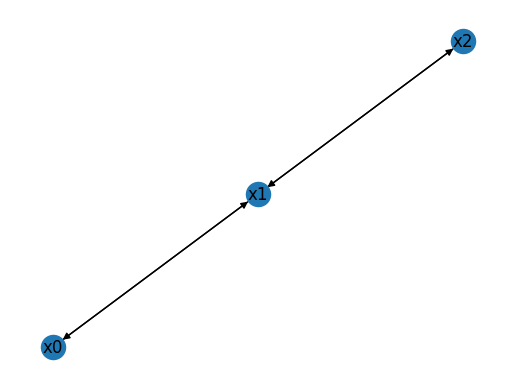

In [2]:
# Wiring diagram of a 3-node network
I = [
    [1],
    [0, 2],
    [1],
]

W = boolforge.WiringDiagram(I=I)

print("W.N:", W.N)
print("W.variables:", W.variables)
print("W.indegrees:", W.indegrees)
print("W.outdegrees:", W.outdegrees)
print("W.N_constants:", W.N_constants)
print("W.N_variables:", W.N_variables)

DiGraph = W.to_DiGraph()
plt.figure()
nx.draw_networkx(DiGraph, with_labels=True, arrows=True)
plt.axis("off")
plt.show()

The wiring diagram above uses default variable names $x_0, \ldots, x_{N-1}$.
The vectors `indegrees` and `outdegrees` describe incoming and outgoing edges
for each node.

### Example with constants and unequal degrees

W.N: 3
W.variables: ['x0' 'x1' 'x2']
W.indegrees: [0 2 1]
W.outdegrees: [2 0 1]
W.N_constants: 1
W.N_variables: 2


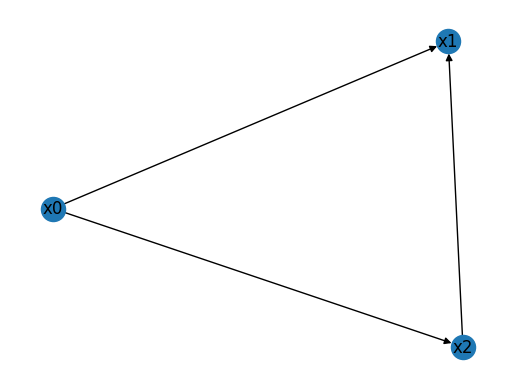

In [3]:
I = [
    [],
    [0, 2],
    [0],
]

W = boolforge.WiringDiagram(I=I)

print("W.N:", W.N)
print("W.variables:", W.variables)
print("W.indegrees:", W.indegrees)
print("W.outdegrees:", W.outdegrees)
print("W.N_constants:", W.N_constants)
print("W.N_variables:", W.N_variables)

DiGraph = W.to_DiGraph()
plt.figure()
nx.draw_networkx(DiGraph, with_labels=True, arrows=True)
plt.axis("off")
plt.show()

This wiring diagram encodes a **feed-forward loop**, one of the most common *network motifs* in 
transcriptional networks. It can:
- filter transient signals (coherent FFL with AND gate),
- accelerate response (incoherent FFL),

See Mangan & Alon, PNAS, 2003 for a detailed analysis.
`BoolForge` enables the identification of all feed-forward loops:

In [4]:
print("W.get_ffls()", W.get_ffls())

W.get_ffls() [[0, 2, 1]]


This tells us that `W` contains one FFL, in which $x_0$ regulates both $x_1$ and $x_2$, 
while $x_1$ is also regulated by $x_2$.

`BoolForge` can also identify all feedback loops. For this, we consider another wiring diagram:

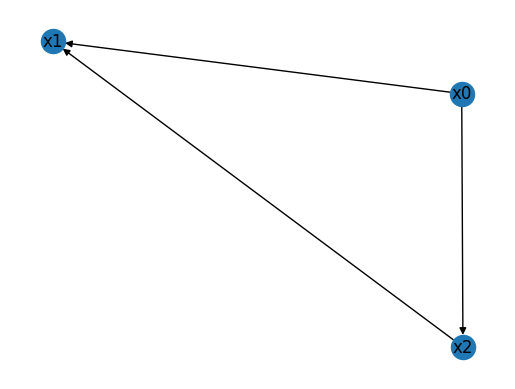

W2.get_fbls() [[0, 1, 2], [0, 1]]


In [5]:
I2 = [
    [2,1],
    [0],
    [1],
]

W2 = boolforge.WiringDiagram(I=I2)
plt.figure()
nx.draw_networkx(DiGraph, with_labels=True, arrows=True)
plt.axis("off")
plt.show()

print("W2.get_fbls()", W2.get_fbls())

The function `.get_fbls()` identifies all simple cycles in the wiring diagram. 
In this case, there exists a 2-cycle $x_0 \leftrightarrow x_1$ and a 3-cycle $x_0 \to x_1 \to x_2 \to x_0$.

---
## 3. Creating Boolean networks

To create a Boolean network, we must specify:

1. A wiring diagram `I`, describing who regulates whom.
2. A list `F` of Boolean update functions (or truth tables), one per node.

In [6]:
I = [
    [1],
    [0, 2],
    [1],
]

F = [
    [0, 1],
    [0, 1, 1, 1],
    [0, 1],
]

bn = boolforge.BooleanNetwork(F=F, I=I)

bn.to_truth_table()

,x0(t),x1(t),x2(t),x0(t+1),x1(t+1),x2(t+1)
0,0,0,0,0,0,0
1,0,0,1,0,1,0
2,0,1,0,1,0,1
3,0,1,1,1,1,1
4,1,0,0,0,1,0
5,1,0,1,0,1,0
6,1,1,0,1,1,1
7,1,1,1,1,1,1


The full truth table of a Boolean network has size $N \times 2^N$ and therefore grows exponentially with the number of nodes.  
In practice, however, `BoolForge` never stores this object explicitly. 
Instead, a Boolean network is represented internally by its wiring diagram `I` and the list of update functions `F`, 
which is far more memory-efficient – especially for sparse networks with few regulators per node.

When a Boolean network is constructed from `F` and `I`, 
`BoolForge` automatically performs a series of consistency checks to guard against common modeling errors. 
For example, it verifies that each update function has the correct length, 
namely $2^n$, where $n$ is the number of regulators of the corresponding node as specified in `I`. 
If any of these checks fail, an informative error is raised immediately, 
helping ensure that the resulting network is well-defined.



### Creating networks from strings

Alternatively, 

In [7]:
string = """
x = y
y = x OR z
z = y
"""

bn_str = boolforge.BooleanNetwork.from_string(string, separator="=")
bn_str.to_truth_table()

,x(t),y(t),z(t),x(t+1),y(t+1),z(t+1)
0,0,0,0,0,0,0
1,0,0,1,0,1,0
2,0,1,0,1,0,1
3,0,1,1,1,1,1
4,1,0,0,0,1,0
5,1,0,1,0,1,0
6,1,1,0,1,1,1
7,1,1,1,1,1,1


This flexible interface enables loading Boolean networks from standard formats
such as `.bnet` files, by first loading the string stored in the file and then loading the Boolean network.

### Interoperability with CANA

In [8]:
cana_bn = bn.to_cana()
bn_from_cana = boolforge.BooleanNetwork.from_cana(cana_bn)

assert (
    np.all([np.all(bn.F[i].f == bn_from_cana.F[i].f) for i in range(bn.N)])
    and np.all([np.all(bn.I[i] == bn_from_cana.I[i]) for i in range(bn.N)])
    and np.all(bn.variables == bn_from_cana.variables)
), "BooleanNetwork CANA conversion failed"

---
## 4. Boolean networks with constants

Nodes may be:

- **source nodes** (no regulators),
- **constant nodes** (fixed to 0 or 1),
- **regular nodes** (regulated by others).

Constant nodes are removed internally, and their values are propagated.

In [9]:
F = [
    [0, 0, 0, 1],  # regular
    [0, 1, 1, 1],  # regular
    [0, 1],        # source
    [0],           # constant
]

I = [
    [1, 2],
    [0, 3],
    [2],
    [],
]

bn = boolforge.BooleanNetwork(F, I)

print("bn.variables:", bn.variables)
print("bn.constants:", bn.constants)
print("bn.F:", bn.F)
print("bn.I:", bn.I)

bn.variables: [np.str_('x0'), np.str_('x1'), np.str_('x2')]
bn.constants: {np.str_('x3'): {'value': 0, 'regulatedNodes': [np.str_('x1')]}}
bn.F: [BooleanFunction(f=[0, 0, 0, 1]), BooleanFunction(f=[0, 1]), BooleanFunction(f=[0, 1])]
bn.I: [array([1, 2]), array([0]), array([2])]


The constant node is removed, and its value is propagated into downstream
update functions.

### Effect of constant value = 1

In [10]:
F = [
    [0, 0, 0, 1],
    [0, 1, 1, 1],
    [0, 1],
    [1],
]

I = [
    [1, 2],
    [0, 3],
    [2],
    [],
]

bn = boolforge.BooleanNetwork(F, I)

print("bn.F:", bn.F)
print("bn.I:", bn.I)
print("bn.variables:", bn.variables)

bn.F: [BooleanFunction(f=[0, 0, 0, 1]), BooleanFunction(f=[1, 1]), BooleanFunction(f=[0, 1])]
bn.I: [array([1, 2]), array([0]), array([2])]
bn.variables: [np.str_('x0'), np.str_('x1'), np.str_('x2')]


Although $x_1$ becomes fixed at 1 after one update, it is not treated as a
constant node because $x_1 = 0$ remains a valid initial condition.

---
## 5. Boolean network properties

The class `BooleanNetwork` inherits all properties of `WiringDiagram`.

In [11]:
print("bn.N:", bn.N)
print("bn.indegrees:", bn.indegrees)
print("bn.outdegrees:", bn.outdegrees)
print("bn.N_constants:", bn.N_constants)
print("bn.N_variables:", bn.N_variables)

bn.N: 3
bn.indegrees: [np.int64(2), np.int64(1), np.int64(1)]
bn.outdegrees: [np.int64(1), np.int64(1), np.int64(2)]
bn.N_constants: 1
bn.N_variables: 3


---
## Outlook

In the remaining tutorials, we build on this foundation to study the dynamical
behavior of Boolean networks, including attractors, basins of attraction,
and stability under perturbations.